In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import cv2
from skimage.morphology import disk
import skimage

In [2]:
def padding(im,filt_sz,pad_type = 'constant'):
    f_h,f_w = filt_sz
    if (f_h-1)%2 != 0 :
        pad_r = ((f_h-1)//2+1,(f_h-1)//2)
    else :
        pad_r = ((f_h-1)//2,(f_h-1)//2)
    if (f_w-1)%2 != 0 :
        pad_w = ((f_w-1)//2+1,(f_w-1)//2)
    else :
        pad_w = ((f_w-1)//2,(f_w-1)//2)
    pad_sz = (pad_r,pad_w)
    im1 = np.pad(im,pad_sz,mode = pad_type)
    return im1

In [3]:
def col_for_conv(im, kernel):
    k_h,k_w = kernel.shape
    im_h,im_w = im.shape
    a = np.transpose(((np.arange(im_h - k_h+1)[:,None] + np.arange(im_w - k_w+1)*im_h).ravel(order='F')[:,None]+ np.arange(k_h))[:,:,None],(1,2,0))
    a = np.reshape(a+im_h*np.arange(k_w)[None,:,None],(k_h*k_w,-1),order='F')
    return im.ravel(order='F')[a]

def fasterconv(im, kernel, do_padding = True, padding_type = 'constant', morph = False):
    if do_padding:
        im = padding(im, kernel.shape, padding_type)
    k_h,k_w = kernel.shape
    im_h,im_w = im.shape
    col_im = col_for_conv(im, kernel)
    kernel_col = kernel.ravel()[:,None]
    if morph:
        xored = np.bitwise_xor(col_im,kernel_col)
        xored[xored<0] = 0
        return np.reshape(((np.sum(xored, axis=0))==0).astype(int), (im_h - k_h+1, im_w - k_w+1) ,order='F')
    else:
        return np.reshape(np.sum(col_im*kernel_col, axis=0), (im_h - k_h+1, im_w - k_w+1) ,order='F')


In [4]:
def skeletonization_pass(im):
    S1 = np.array(([[0,0,0],[-1,1,-1],[1,1,1]]))
    S2 = np.array(([[-1,0,0],[1,1,0],[-1,1,-1]]))

    rot = [0, 3, 2, 1]
    ret = deepcopy(im)
    for r in rot:
        prev_ret = deepcopy(ret)
        ret = ret - fasterconv(ret, np.rot90(S1,r),morph = True)
        ret = ret - fasterconv(ret, np.rot90(S2,r),morph = True)
        if np.all(prev_ret == ret):
            return [ret, True]
    return [ret, False]

def skeletonization(im):
    ret = deepcopy(im)
    while True:
        ret = skeletonization_pass(ret)
        if ret[1]:
            return ret[0]
        else:
            ret = ret[0]

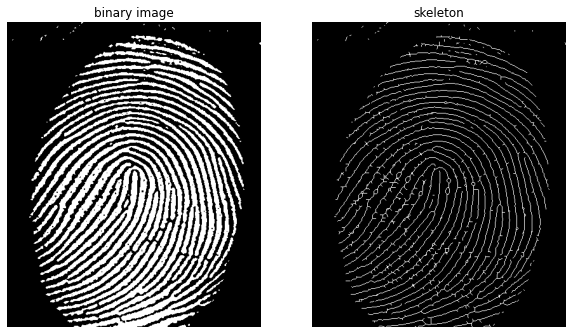

In [5]:
noisy = cv2.imread("../images/thumb_print.jpg", 0)
_, thresholded_noisy = cv2.threshold(noisy,90,255,cv2.THRESH_BINARY)
skeleton = skeletonization((1-thresholded_noisy/255).astype(int))*255

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("binary image") ;ax[1].title.set_text("skeleton")
ax[0].imshow(1 - thresholded_noisy/255, 'gray')
ax[1].imshow(skeleton, 'gray'); plt.show()

 - The process of skeletonization requires thinning of edges
 - S1 helps in thinning of horizontal and vertical edges
 - S2 helps in thinning of corners and diagonal edges 

Since one pass results in scraping of one layer of the image, we need to do multiple passes to get the required skeleton.

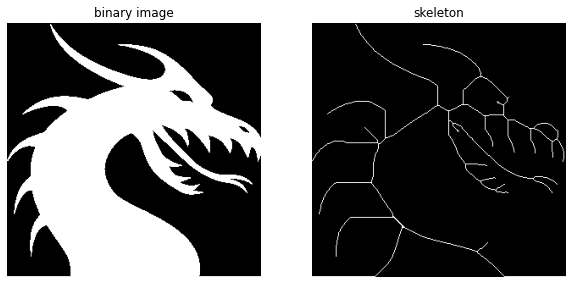

In [5]:
# dragon
dragon = cv2.imread("../images/dragon.png", 0)
_, thresholded_dragon = cv2.threshold(dragon,90,255,cv2.THRESH_BINARY)
skeleton_dragon = skeletonization((thresholded_dragon/255).astype(int))*255

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("binary image") ;ax[1].title.set_text("skeleton")
ax[0].imshow(thresholded_dragon/255, 'gray')
ax[1].imshow(skeleton_dragon, 'gray'); plt.show()

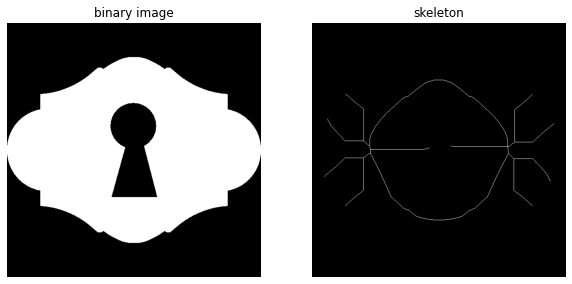

In [7]:
#keyhole
keyhole = cv2.imread("../images/keyhole.jpg", 0)
_, thresholded_keyhole = cv2.threshold(keyhole,90,255,cv2.THRESH_BINARY)
skeleton_keyhole = skeletonization((thresholded_keyhole/255).astype(int))*255

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("binary image") ;ax[1].title.set_text("skeleton")
ax[0].imshow(thresholded_keyhole/255, 'gray')
ax[1].imshow(skeleton_keyhole, 'gray'); plt.show()

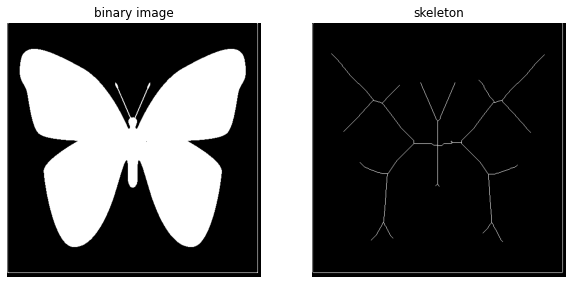

In [8]:
#butterfly
butterfly = cv2.imread("../images/butterfly.jpg", 0)
_, thresholded_butterfly = cv2.threshold(butterfly,90,255,cv2.THRESH_BINARY)
skeleton_butterfly = skeletonization((thresholded_butterfly/255).astype(int))*255

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("binary image") ;ax[1].title.set_text("skeleton")
ax[0].imshow(thresholded_butterfly/255, 'gray')
ax[1].imshow(skeleton_butterfly, 'gray'); plt.show()

In [9]:
def imerode(im, kernel):
    kernel[kernel==0]=-1
    return fasterconv(im, kernel, morph=True)

def imdilate(im, kernel):
    im = padding(im, kernel.shape, 'constant')
    k_h,k_w = kernel.shape
    im_h,im_w = im.shape
    col_im = col_for_conv(im, kernel)
    kernel_col = kernel.ravel()[:,None]
    xored = col_im*kernel_col
    # print(xored.min(), xored.max())
    # return np.reshape((np.max(((xored-1)/(-1)).astype(int), axis=0)).astype(int), (im_h - k_h+1, im_w - k_w+1) ,order='F')
    return np.reshape((np.max((xored).astype(int), axis=0)).astype(int), (im_h - k_h+1, im_w - k_w+1) ,order='F')

def imopen(im,kernel):
    return imdilate(imerode(im, kernel), kernel)

def imclose(im, kernel):
    return imerode(imdilate(im, kernel), kernel)

def rgblabel(im):
    im1 = deepcopy(im)
    im2 = im1*1
    im3 = im1*1
    labels = np.unique(im1)
    for i in labels[1:]:
        tmp = np.random.randint(65,255,size = 3)
        im1[im1==i] = tmp[0]
        im2[im2==i] = tmp[1]
        im3[im3==i] = tmp[2]
    
    return np.stack((im1,im2,im3),axis=2)

def connected_components(im, connectivity = 4):
    parent_dict = {}
    component_num = 1

    ret = deepcopy(im)
    # firstpass
    for j in range(im.shape[0]):
        for i in range(im.shape[1]):
            if im[j,i] == 1:
                num1 = np.inf
                num2 = np.inf
                num3 = np.inf
                num4 = np.inf
                if j-1>=0 and im[j-1,i]>0:
                    num1 = ret[j-1,i]
                    if connectivity == 8 and (not i+1>im.shape[1]-1) and im[j-1,i+1]>0:
                        num4 = ret[j-1, i+1]
                if i-1>=0 and im[j,i-1]>0:
                    num2 = ret[j,i-1]
                    if connectivity == 8 and (not j-1>=0) and im[j-1,i-1]>0:
                        num3 = ret[j-1, i-1]

                # print(num1, num2, num3)
                if (not (num1 == np.inf)) or (not(num2 == np.inf)) or (not(num3 == np.inf)) or (not(num4 == np.inf)):
                    ret[j,i] = min(num1, num2, num3, num4)
                    non_inf = []
                    for number in [num1, num2, num3, num4]:
                        if not (number == np.inf):
                            non_inf.append(number)
                    # print(num1, num2, num3)
                    # if len(non_inf)<2:
                    #     continue
                    for number in non_inf:
                        if not (number == min(non_inf)):
                            parent_dict[number] = min(non_inf)
                            
                else:
                    ret[j,i] = component_num
                    component_num = component_num + 1
                # if ((not (num1 == np.inf)) and (not(num2 == np.inf))) or ((not (num2 == np.inf)) and (not(num3 == np.inf))) or ((not (num3 == np.inf)) and (not(num1 == np.inf))):
    # plt.imshow(rgblabel(ret)); plt.show()
    
    # print(parent_dict)

    # second pass
    for j in range(im.shape[0]):
        for i in range(im.shape[1]):
            if im[j,i]==0:
                continue
            key = ret[j,i]
            while key in parent_dict.keys():
                prev_key = key
                key = parent_dict[key]
                parent_dict[prev_key] = key
            ret[j,i] = key
            # print('not a key', key)

    return ret

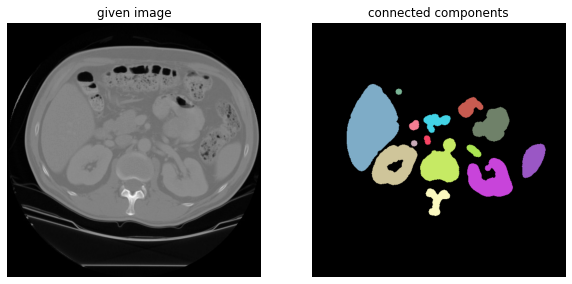

In [10]:
kidney = cv2.imread("../images/kidney.jpg", 0)
_, thresholded_kidney = cv2.threshold(kidney,129,255,cv2.THRESH_BINARY)
kernel = np.ones((6,6)).astype(int)
# thresholded_kidney = imerode((thresholded_kidney/255).astype(int),disk(6, int))

thresholded_kidney = imclose(imopen((thresholded_kidney/255).astype(int),disk(6, int)),disk(2, int))
thresholded_kidney = rgblabel(connected_components(thresholded_kidney))

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("connected components")
ax[0].imshow(kidney, 'gray')
ax[1].imshow(thresholded_kidney); plt.show()

(773, 444)


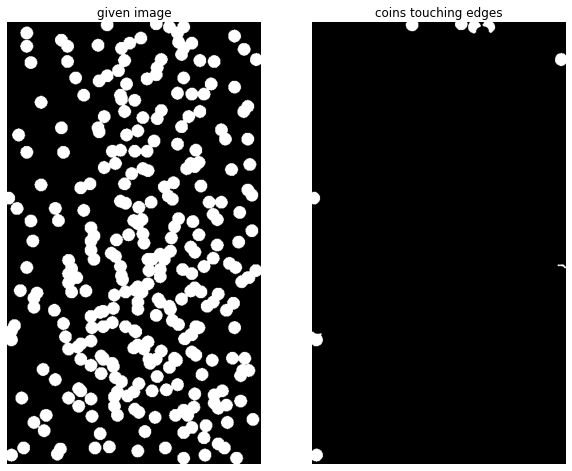

In [11]:
coins = cv2.imread("../images/coins.jpg", 0)
print(coins.shape)
_,coins = cv2.threshold(coins,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
coins_edge = imopen(coins//255 - imopen(coins//255,disk(10, int)),disk(1, int))

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("coins touching edges")
ax[0].imshow(coins, 'gray')
ax[1].imshow(coins_edge, 'gray'); plt.show()

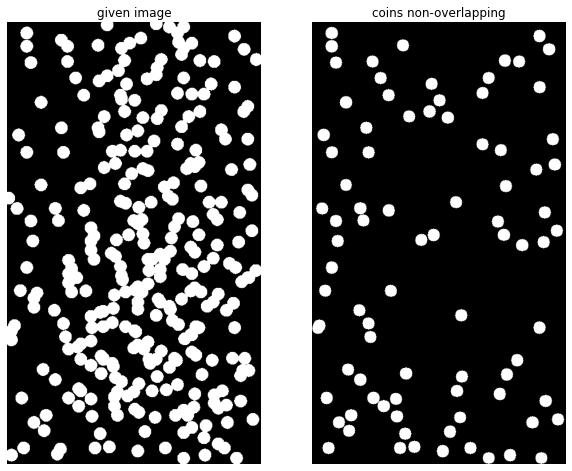

In [12]:
coins_non_overlapping = imopen(coins//255,disk(10, int))
coins_n_o_components = connected_components(coins_non_overlapping)
u,inv,cnt = np.unique(coins_n_o_components,return_inverse = True,return_counts = True)
cnt[cnt <= 470] = -1
cnt = (cnt<0).astype('uint')
coins_non_overlapping = cnt[inv].reshape(coins.shape)>0

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("coins non-overlapping")
ax[0].imshow(coins, 'gray')
ax[1].imshow(coins_non_overlapping, 'gray'); plt.show()

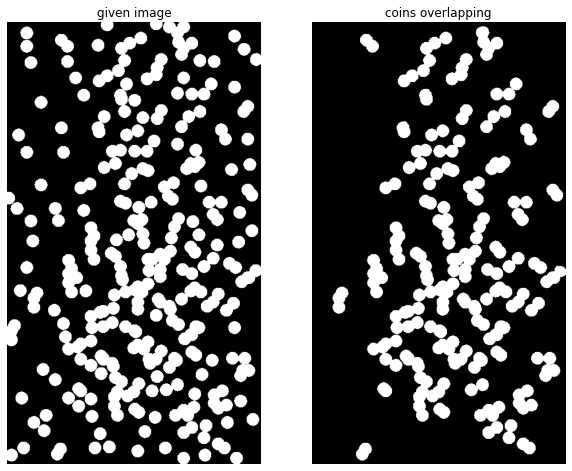

In [13]:
coins_overlapping = imopen(coins//255 - coins_edge - coins_non_overlapping ,disk(1, int))

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("coins overlapping")
ax[0].imshow(coins, 'gray')
ax[1].imshow(coins_overlapping, 'gray'); plt.show()

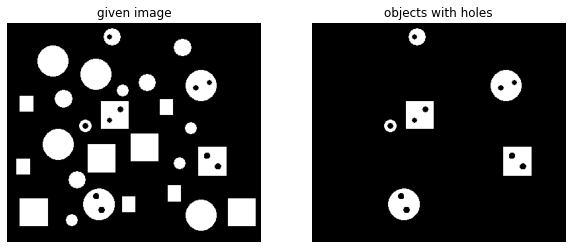

In [14]:
objects = cv2.imread("../images/objects.png", 0)
objects_ = connected_components(1 - objects//255)
u,inv,cnt = np.unique(objects_,return_inverse = True,return_counts = True)
cnt[cnt <= 80] = -1; cnt = (cnt<0).astype('uint')
holes = cnt[inv].reshape(objects.shape)>0
holes_filled = holes + objects//255
objects_comp = connected_components(objects//255)
holes_filled_comp = connected_components(holes_filled)
u1,inv1,cnt1 = np.unique(holes_filled_comp,return_inverse = True,return_counts = True)
u2,inv2,cnt2 = np.unique(objects_comp,return_inverse = True,return_counts = True)

cnt1[0] = 0
cnt2[0] = 0
hole_objects = ((cnt1 - cnt2)!=0)[inv2].reshape(objects.shape)

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("objects with holes")
ax[0].imshow(objects, 'gray')
ax[1].imshow(hole_objects, 'gray'); plt.show()

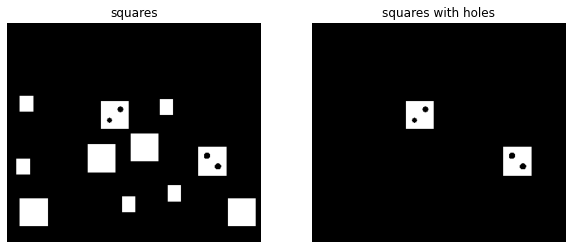

In [15]:
kernel = np.array([[0,0,0],[0,1,1],[0,1,1]])
squares_position = fasterconv(objects//255, kernel, morph=True)
squares_comp = objects_comp*squares_position
u3,inv3,cnt3 = np.unique(squares_comp,return_inverse = True,return_counts = True)
u4 = np.isin(u2,u3); u4[0] = False
squares = u4[inv2].reshape(objects.shape)
squares_holes = squares & hole_objects

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("squares") ;ax[1].title.set_text("squares with holes")
ax[0].imshow(squares, 'gray')
ax[1].imshow(squares_holes, 'gray'); plt.show()

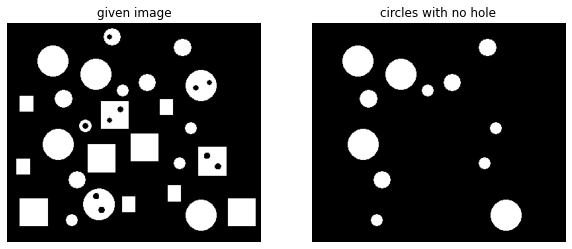

In [16]:
circle_without_holes = objects//255 - squares.astype(int) - (hole_objects.astype(int) - squares_holes.astype(int))

f, ax = plt.subplots(1, 2, figsize=(10,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("circles with no hole")
ax[0].imshow(objects, 'gray')
ax[1].imshow(circle_without_holes, 'gray'); plt.show()

different_components = 24


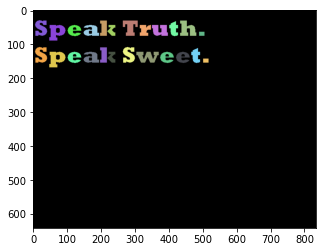

In [17]:
col_text = cv2.cvtColor(cv2.imread("../images/colourful_text.png"), cv2.COLOR_BGR2RGB)
col_text = col_text[18:678-18,18:871-18]
col1 = np.bitwise_and(col_text[:,:,0]>220,col_text[:,:,1]<10).astype(int)

col1_comp = connected_components(col1, connectivity=8)
print('different_components =', len(np.unique(col1_comp))-1)
plt.imshow(rgblabel(col1_comp), 'gray');plt.show()

different_components = 27


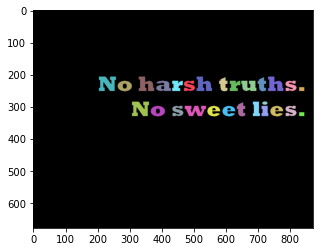

In [18]:
col_text = cv2.cvtColor(cv2.imread("../images/colourful_text.png"), cv2.COLOR_BGR2RGB)
# col2 = col_text[18:678-18,18:871-18]
col2 = np.bitwise_and(np.bitwise_and(col_text[:,:,0]<=31,col_text[:,:,1]<=74),col_text[:,:,2]>=125).astype(int)

col2_comp = connected_components(col2, connectivity=8)
print('different_components =', len(np.unique(col2_comp))-1)
plt.imshow(rgblabel(col2_comp), 'gray');plt.show()

different_components = 256


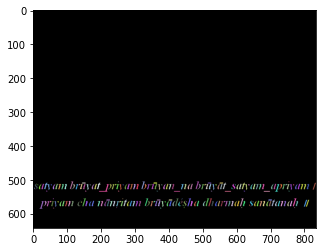

In [19]:
col3 = col_text[18:678-18,18:871-18]
col3 = np.bitwise_and(np.bitwise_and(col3[:,:,0]==0,col3[:,:,1]==0),col3[:,:,2]==0).astype(int)
col3_comp = connected_components(col3, connectivity=8)
print('different_components =', len(np.unique(col3_comp))-1)
plt.imshow(rgblabel(col3_comp), 'gray');plt.show()

different_components = 27


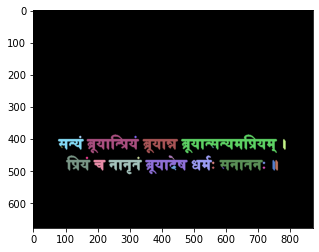

In [20]:
col4 = imdilate(np.bitwise_and(np.bitwise_and(col_text[:,:,0]==0,col_text[:,:,1]==176),col_text[:,:,2]==80).astype(int), disk(2, int))
col4_comp = connected_components(col4, connectivity=8)
print('different_components =', len(np.unique(col4_comp))-1)
plt.imshow(rgblabel(col4_comp), 'gray');plt.show()

different_components = 35


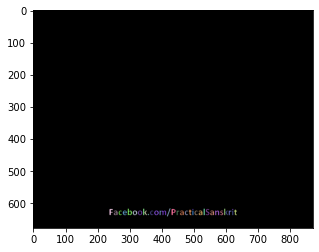

In [21]:
col5 = np.bitwise_and(np.bitwise_and(col_text[:,:,0]==112,col_text[:,:,1]==48),col_text[:,:,2]==160).astype(int)
col5_comp = connected_components(col5, connectivity=8)
print('different_components =', len(np.unique(col5_comp))-1)
plt.imshow(rgblabel(col5_comp), 'gray');plt.show()

In [33]:
telugu = cv2.cvtColor(cv2.imread("../images/telugu.jpeg"), cv2.COLOR_BGR2GRAY)
telugu = cv2.adaptiveThreshold(telugu, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,14)
# telugu = imerode((telugu/255).astype(int), disk(1,int))
# plt.imshow(telugu, 'gray')
telugu_comp = connected_components(telugu/255, 8)
u,inv,cnt = np.unique(telugu_comp, return_inverse = True,return_counts = True)
cnt[cnt<=200] = -1
cnt = (cnt<0).astype(int)
holes =  cnt[inv].reshape(telugu.shape)
filled_telugu_comp = connected_components((1-telugu/255) + holes, 8)
holes_comp = holes*filled_telugu_comp
u1,inv1,cnt1 = np.unique(holes_comp,return_inverse = True,return_counts = True)
num_holes = np.zeros(u1.size)
j = 1
for i in u1[1:]:
    u3 = (u1==i).astype('uint')
    hole_i = u3[inv1].reshape(telugu.shape)
    hole_i_comp = connected_components(hole_i, 8)
    num_holes[j] = np.unique(hole_i_comp).size - 1
    j+=1
u2,inv2,cnt2 = np.unique(filled_telugu_comp,return_inverse = True,return_counts = True)
tmp1 = np.isin(u2,u1*(num_holes==1))
tmp2 = np.isin(u2,u1*(np.array(num_holes>=2) & np.array(num_holes<=4)))
tmp1[0] = False
tmp2[0] = False

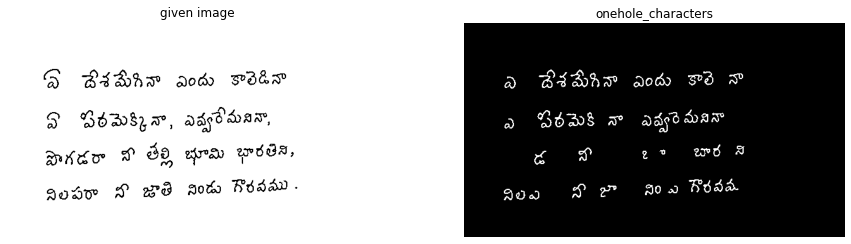

In [34]:
onehole_characters = tmp1[inv2].reshape(telugu.shape)
onehole = ((num_holes==1)[inv1]).astype(int).reshape(telugu.shape)
f, ax = plt.subplots(1, 2, figsize=(15,15))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("onehole_characters")
ax[0].imshow(telugu, 'gray')
ax[1].imshow(onehole_characters - onehole, 'gray'); plt.show()

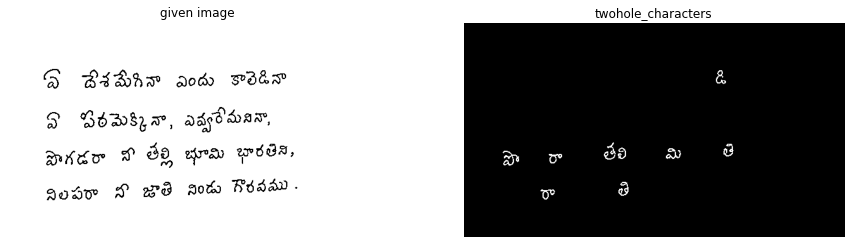

In [35]:
twohole_characters = tmp2[inv2].reshape(telugu.shape)
twohole = ((np.array(num_holes>=2) & np.array(num_holes<=4))[inv1]).astype(int).reshape(telugu.shape)
f, ax = plt.subplots(1, 2, figsize=(15,15))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("twohole_characters")
ax[0].imshow(telugu, 'gray')
ax[1].imshow(twohole_characters - twohole, 'gray'); plt.show()

In [36]:
tamil = cv2.cvtColor(cv2.imread("../images/tamil.jpeg"), cv2.COLOR_BGR2GRAY)
tamil = cv2.adaptiveThreshold(tamil, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,14)
tamil = 255*imerode((tamil/255).astype(int), disk(1, int))
# plt.imshow(tamil, 'gray')
tamil_comp = connected_components(tamil/255, 8)
u,inv,cnt = np.unique(tamil_comp, return_inverse = True,return_counts = True)
cnt[cnt<=250] = -1
cnt = (cnt<0).astype(int)
holes =  cnt[inv].reshape(tamil.shape)
# plt.imshow(holes, 'gray')
filled_tamil_comp = connected_components((1-tamil/255) + holes, 8)
holes_comp = holes*filled_tamil_comp
u1,inv1,cnt1 = np.unique(holes_comp,return_inverse = True,return_counts = True)
num_holes = np.zeros(u1.size)
j = 1
for i in u1[1:]:
    u3 = (u1==i).astype('uint')
    hole_i = u3[inv1].reshape(tamil.shape)
    hole_i_comp = connected_components(hole_i, 8)
    num_holes[j] = np.unique(hole_i_comp).size - 1
    j+=1
u2,inv2,cnt2 = np.unique(filled_tamil_comp,return_inverse = True,return_counts = True)
tmp1 = np.isin(u2,u1*(num_holes==1))

In [37]:

# print(np.array(num_holes>=2) & np.array(num_holes<=3))
# print(num_holes<=3)
tmp2 = np.isin(u2,u1*(np.array(num_holes>=2) & np.array(num_holes<=4)))
tmp1[0] = False
tmp2[0] = False

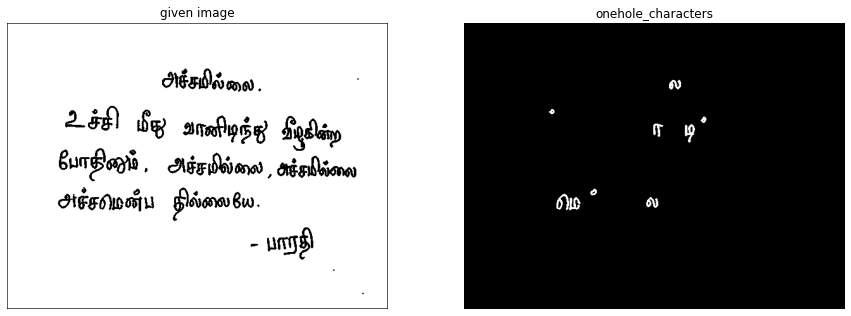

In [38]:
onehole_characters = tmp1[inv2].reshape(tamil.shape)
# plt.imshow(onehole_characters)
onehole = ((num_holes==1)[inv1]).astype(int).reshape(tamil.shape)
f, ax = plt.subplots(1, 2, figsize=(15,15))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("onehole_characters")
ax[0].imshow(tamil, 'gray')
ax[1].imshow(onehole_characters - onehole, 'gray'); plt.show()

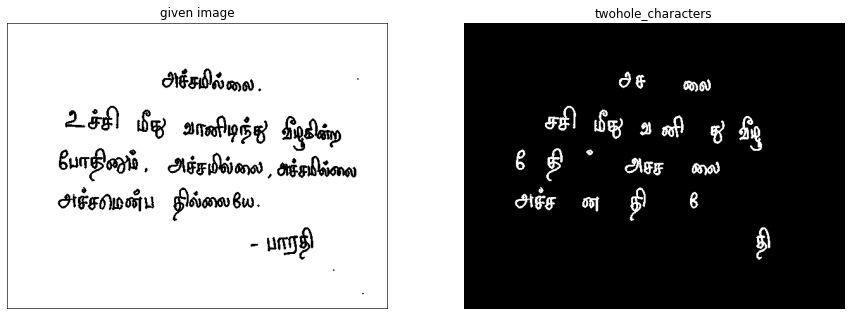

In [39]:
twohole_characters = tmp2[inv2].reshape(tamil.shape)
twohole = (((np.array(num_holes>=2) & np.array(num_holes<=4)))[inv1]).astype(int).reshape(tamil.shape)
f, ax = plt.subplots(1, 2, figsize=(15,15))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0].title.set_text("given image") ;ax[1].title.set_text("twohole_characters")
ax[0].imshow(tamil, 'gray')
ax[1].imshow(twohole_characters - twohole, 'gray'); plt.show()

### a)
1. We first we create a new image with the new scaled dimensions filled with zeros.
2. Then, we do backward mapping for each pixel of the new image by dividing the x-coordinate with the scaling factor along the x direction and the y-coordinate by the scaling factor along the y direction.

*The main problem arises here*
- We can either choose some form of interpolation method or choose the neared integer value to location of the pixel intensity we want to choose from the original image.

- Suppose we choose an interpolation method (say averaging), we average over all the nearby pixel values, thus corrupting the label (we get a completely new label which never existed in the first place).

- If we choose nearest integer, we will obtain a label which is already existing thus ensuring that no new labels are created.



### b)

1. We first we create a new image with the new dimensions filled with zeros.
2. Then, we do backward mapping for each pixel of the new image by multiplying a pixel location with the inverse of the transformation matrix.

*The main problem arises here*
- We can either choose some form of interpolation method or choose the neared integer value to location of the pixel intensity we want to choose from the original image.

- Suppose we choose an interpolation method (say averaging), we average over all the nearby pixel values, thus corrupting the label (we get a completely new label which never existed in the first place).

- If we choose nearest integer neighbour, we will obtain a label which is already existing thus ensuring that no new labels are created.


In [29]:
def rotImange(im, angle, retain = True, degrees = True):
    if degrees:
        angle = angle%360
        angle = (angle*np.pi)/180
    h,w = im.shape
    
    if not retain:
        x0 = im.shape[0]//2-1; y0 = im.shape[1]//2-1
        ind1 = [0,im.shape[0]-1]; ind2 = [0,im.shape[1]-1]
        a = []; b = []
        for i in ind1:
            for j in ind2:
                a.append(int(x0 +(i-x0)*np.cos(angle)+(j-y0)*np.sin(angle)))
                b.append(int(x0 +(i-x0)*np.cos(angle)+(j-y0)*np.sin(angle)))
        # Y0 = abs(int(x0 +(0-x0)*np.cos(angle)+(0-y0)*np.sin(angle)))
        # X0 = abs(int(x0 +(h-x0)*np.cos(angle)+(0-y0)*np.sin(angle)))
        pad0 = abs(min(a)); pad1 = abs(min(b))
        
        im = np.hstack((np.zeros((im.shape[0], pad0)), im, np.zeros((im.shape[0], pad0))))
        # print(im.shape)
        im = np.vstack((np.zeros((pad1, im.shape[1])), im, np.zeros((pad1, im.shape[1]))))

        # plt.imshow(im); plt.show()    

    if True:
        h,w = im.shape
        im_new = np.zeros(im.shape)
        x0 = h//2-1; y0 = w//2-1
        for i in range(h):
            for j in range(w):
                x=int(x0 +(i-x0)*np.cos(angle)+(j-y0)*np.sin(angle))
                y=int(y0 -(i-x0)*np.sin(angle)+(j-y0)*np.cos(angle))
                if (not(x<0 or x>=h) and (not(y<0 or y>=w))):
                    im_new[i,j] = im[x,y]
        return im_new

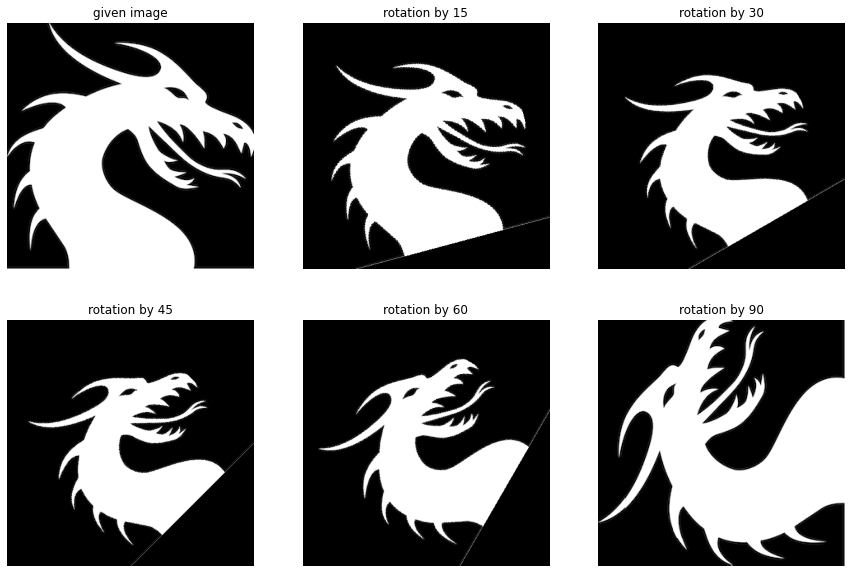

In [30]:
dragon = cv2.imread("../images/dragon.png", 0)
rot_dragon_15 = rotImange(dragon, 15)
rot_dragon_30 = rotImange(dragon, 30)
rot_dragon_45 = rotImange(dragon, 45)
rot_dragon_60 = rotImange(dragon, 60)
rot_dragon_90 = rotImange(dragon, 90)
# print(rot_dragon)
# plt.imshow(rot_dragon, 'gray')

f, ax = plt.subplots(2, 3, figsize=(15,10))
[axi.set_axis_off() for axi in ax[:].ravel()]
ax[0,0].title.set_text("given image") ;ax[0,1].title.set_text("rotation by 15")
ax[0,2].title.set_text("rotation by 30") ;ax[1,0].title.set_text("rotation by 45")
ax[1,1].title.set_text("rotation by 60") ;ax[1,2].title.set_text("rotation by 90")

ax[0,0].imshow(dragon, 'gray')
ax[0,1].imshow(rot_dragon_15, 'gray')
ax[0,2].imshow(rot_dragon_30, 'gray')
ax[1,0].imshow(rot_dragon_45, 'gray')
ax[1,1].imshow(rot_dragon_60, 'gray')
ax[1,2].imshow(rot_dragon_90, 'gray')

plt.show()